In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re, string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string

In [2]:
IMDB = pd.read_csv('IMDB Dataset.csv')

In [3]:
IMDB.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Descriptive Statistics ##

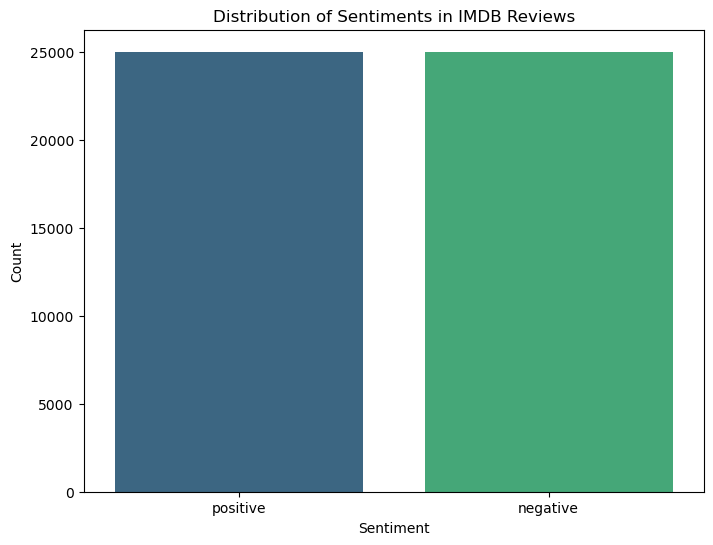

In [4]:
# Create a bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=IMDB, palette='viridis')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in IMDB Reviews')

# Show the plot
plt.show()

From the bar chart we can see that there are 50,000 reviews with an equal amount of positive and negative reviews.

In [5]:
IMDB['sentiment'] = IMDB['sentiment'].map({'positive': 1, 'negative': 0})

In [6]:
IMDB.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [7]:
X = IMDB['review']
y = IMDB['sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    random_state=9)

In [8]:
y_train


30309    0
48725    1
14609    0
11364    1
11850    1
        ..
5014     1
42747    1
22584    1
501      1
20828    0
Name: sentiment, Length: 40000, dtype: int64

In [9]:
y_test.value_counts()

sentiment
0    5023
1    4977
Name: count, dtype: int64

In [10]:
def process_string(review):
  # 1. Remove tags (things like <...>)
    review = re.sub(r'<.*?>', '', review)

    # 2. Remove punctuation and make all letters lowercase
    review = review.lower()
    review = review.translate(str.maketrans('', '', string.punctuation))

    # 3. Remove duplicate spaces, e.g., '     ' -> ' '
    review = ' '.join(review.split())
    
    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    review = ' '.join(word for word in review.split() if word not in stop_words)

    return review

# demo
print("Example of a preprocessed text:")
print(process_string(x_train[112]))

Example of a preprocessed text:
terrific funny movie doesnt make smile pity film boring long simply painfull story staggering without goal funyou feel better finished


In [11]:
X_train = x_train.apply(process_string)
X_test = x_test.apply(process_string)

In [12]:
count_vect = CountVectorizer(min_df=5)
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

print("Train shape:", X_train_counts.shape, "Test shape:", X_test_counts.shape)

Train shape: (40000, 37006) Test shape: (10000, 37006)


In [13]:
import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

def adverb_to_adjective(text):
    # Tokenize the words
    words = WordPunctTokenizer().tokenize(text)

    # Get part-of-speech tags
    pos_tags = pos_tag(words)

    # Map Penn Treebank POS tags to WordNet POS tags
    def penn_to_wordnet_pos(tag):
        
        if tag.startswith('R'):
            return wordnet.ADV
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        else:
            return wordnet.NOUN  # Default to noun if not found

    # Lemmatize words and transform adverbs to adjectives
    lemmatizer = nltk.WordNetLemmatizer()
    transformed_words = [lemmatizer.lemmatize(word, pos=penn_to_wordnet_pos(tag)) if tag.startswith('R') else word for word, tag in pos_tags]

    # Join the words back into a sentence
    transformed_text = ' '.join(transformed_words)
    return transformed_text

# Example usage
original_text = "She spoke quickly and walked slowly."
transformed_text = adverb_to_adjective(original_text)

print("Original Text:", original_text)
print("Transformed Text:", transformed_text)


Original Text: She spoke quickly and walked slowly.
Transformed Text: She spoke quickly and walked slowly .


In [14]:
from itertools import chain
from nltk.corpus import wordnet as wn
from difflib import get_close_matches as gcm

possible_adj = []
for ss in wn.synsets('terribly'):
    for lemmas in ss.lemmas(): # all possible lemmas
        for ps in lemmas.pertainyms(): # all possible pertainyms
            possible_adj.append(ps.name())

In [15]:
possible_adj

['terrible', 'atrocious', 'awful', 'rotten']